[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/annanasnas/semantic_segmentation-25/blob/main/DeepLabV2.ipynb)

In [1]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [2]:
REPO = "https://github.com/annanasnas/semantic_segmentation-25.git"
!git clone $REPO
%cd /content/semantic_segmentation-25
!pip install -q -r requirements.txt pyyaml

Cloning into 'semantic_segmentation-25'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 170 (delta 73), reused 134 (delta 41), pack-reused 0 (from 0)
Receiving objects: 100% (170/170), 310.97 KiB | 10.37 MiB/s, done.
Resolving deltas: 100% (73/73), done.
/content/semantic_segmentation-25
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Config

In [3]:
import yaml

with open("configs/domain shift.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

!python scripts/download_data.py

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = cfg["train"]["batch_size"]
epochs = cfg["train"]["epochs"]
learning_rate = cfg["train"]["lr"]

dir_train = cfg["data"]["dir_train"]
dir_val = cfg["data"]["dir_val"]
img_size_train = cfg["data"]["img_size_train"]
img_size_val = cfg["data"]["img_size_val"]

name = cfg["model"]["name"]

## DataLoaders

In [4]:
from datasets.cityscapes import CityScapes
from datasets.gta5 import GTA5Dataset
from torch.utils.data import DataLoader
from torchvision import transforms


imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_dataset = GTA5Dataset(
    root_dir=dir_train,
    image_transform=image_transforms,
    image_size=img_size_train
)

val_dataset = CityScapes(
    root_dir=dir_val,
    split="val",
    image_transform=image_transforms,
    image_size=img_size_val
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Training

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch.optim as optim
import torch.nn as nn
from models.bisenet.build_bisenet import BiSeNet
from scripts.train import train_model
from torch.amp import autocast, GradScaler
from scripts.checkpoint import Checkpoint
from pathlib import Path
import pandas as pd

model = BiSeNet(num_classes=19, context_path='resnet18')
optimizer = optim.SGD(model.optim_parameters(lr=learning_rate), momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)
scaler = GradScaler()

model.to(device)

ckpt_dir = Path("/content/drive/MyDrive/semantic segmentation/checkpoints") / name
log_csv  = ckpt_dir / "log.csv"
ckpt_mgr = Checkpoint(ckpt_dir)
ckpt = Checkpoint(ckpt_dir)

best_path = ckpt_dir / "best.pth"
if best_path.exists():
    ckpt = torch.load(best_path, map_location="cpu", weights_only=False)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    scaler.load_state_dict(ckpt["scaler"])
    start_epoch = ckpt["epoch"]
    iteration = ckpt["iteration"]
    best_miou   = ckpt["best_miou"]
    df_prev = pd.read_csv(log_csv)
    metrics = df_prev.to_dict("list")
else:
    start_epoch = 0
    best_miou   = 0
    iteration = 0
    metrics = {"epoch": [], "train_loss": [], "val_loss": [], "val_miou": []}

max_iter = len(train_dataloader) * epochs
train_model(model, train_dataloader, val_dataloader,
            device, epochs, autocast, scaler,
            optimizer, criterion, learning_rate,
            iteration, max_iter,
            ckpt_mgr, start_epoch, best_miou,
            log_csv, metrics)

# Results

In [ ]:
from scripts.utils import evaluate_miou

CITYSCAPES_CLASSES = [
    'Road', 'Sidewalk', 'Building', 'Wall', 'Fence', 'Pole', 'Traffic light',
    'Traffic sign', 'Vegetation', 'Terrain', 'Sky', 'Person', 'Rider', 'Car',
    'Truck', 'Bus', 'Train', 'Motorcycle', 'Bicycle'
]

model = BiSeNet(num_classes=19, context_path='resnet18')
best_model = torch.load(best_path, map_location=device)
model.load_state_dict(best_model["model"])
ious = evaluate_miou(model, val_dataloader, device) * 100

print("Per-class IoU")
for idx, (cls_name, iou) in enumerate(zip(CITYSCAPES_CLASSES, ious)):
    print(f"{cls_name:16s}: {iou:.4f}")
print(f"Mean IoU: {np.nanmean(ious):.4f}")


| Model               | Latency                                                                  | FLOPs   | Params   |   mIoU (%) |
|:--------------------|:-------------------------------------------------------------------------|:--------|:---------|-----------:|
| bisenet - 50 epochs | Mean latency: 0.02 +/- 0.01, Mean FPS: 68.38 +/- 13.14 frames per second | 25.8 G  | 12.6 M   |    54.3385 |


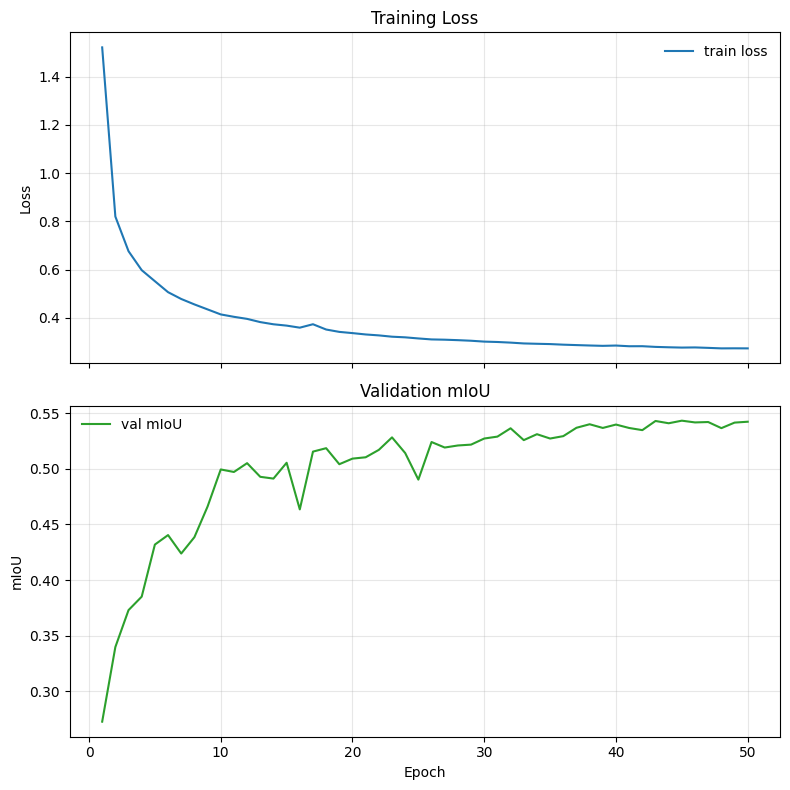

In [3]:
from scripts.utils import plot_log

plot_log(log_csv)

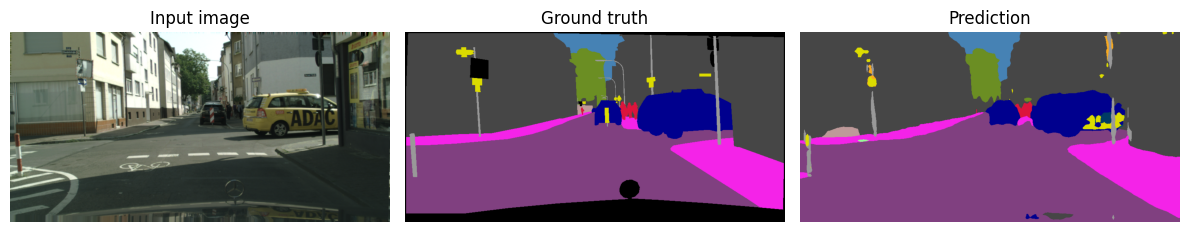

In [7]:
from scripts.utils import visualize_sample

visualize_sample(val_dataloader, model)